# EIA Energy Demand Data
https://www.eia.gov/opendata/

The United States Energy Information Agency (EIA) provides open access to hundreds of thousands of time series datasets via a REST API. The data is in the public domain, but does require [registraton and an API key](https://www.eia.gov/opendata/register.php).

In this notebook I'll explore the data source by extracting historical energy demand via API call. 

In [2]:
import requests
import os
from dotenv import load_dotenv
from pprint import pprint
import pandas as pd
import pytz

load_dotenv()
EIA_KEY = os.getenv('EIA_KEY')

Hourly energy demand for the Public Service Company of Colorado in UTC time has the series ID `EBA.PSCO-ALL.D.H`. I can use the `requests` library to pull the data.

In [3]:
url = 'https://api.eia.gov/series/'
series_id = 'EBA.PSCO-ALL.D.H'

params = {'api_key': EIA_KEY,
          'series_id': series_id,
          'start': '2019'}

r = requests.get(url, params)
r

<Response [200]>

The response comes in a json file that looks like this:

In [5]:
r.json()

{'request': {'command': 'series', 'series_id': 'EBA.PSCO-ALL.D.H'},
 'series': [{'series_id': 'EBA.PSCO-ALL.D.H',
   'name': 'Demand for Public Service Company of Colorado (PSCO), hourly - UTC time',
   'units': 'megawatthours',
   'f': 'H',
   'description': 'Timestamps follow the ISO8601 standard (https://en.wikipedia.org/wiki/ISO_8601). Hourly representations are provided in Universal Time.',
   'start': '20150701T07Z',
   'end': '20220306T03Z',
   'updated': '2022-03-05T22:46:51-0500',
   'data': [['20220306T03Z', 6174],
    ['20220306T02Z', 6290],
    ['20220306T01Z', 6157],
    ['20220306T00Z', 5866],
    ['20220305T23Z', 5662],
    ['20220305T22Z', 5709],
    ['20220305T21Z', 5736],
    ['20220305T20Z', 5785],
    ['20220305T19Z', 5776],
    ['20220305T18Z', 5771],
    ['20220305T17Z', 5659],
    ['20220305T16Z', 5451],
    ['20220305T15Z', 5271],
    ['20220305T14Z', 5092],
    ['20220305T13Z', 4896],
    ['20220305T12Z', 4752],
    ['20220305T11Z', 4670],
    ['20220305T10Z', 

To extract the actual data series, we will need to parse the JSON into a dataframe.

In [17]:
for series in r.json()['series']:
    data=series['data']
    series_id=series['series_id']

In [18]:
mountain = pytz.timezone('US/Mountain')

df = (pd.DataFrame(data, columns=['timestamp', series_id])
        .assign(timestamp=lambda df_:pd.to_datetime(df_['timestamp']))
        .set_index('timestamp')
     )

df.index = df.index.tz_convert(mountain)


Below are some analysis into the different levels of cyclicly in the data.

Seasonal: during the cold parts of the winter, and the hot parts of the summer, there is higher demand than in the spring and fall.

<AxesSubplot:xlabel='timestamp'>

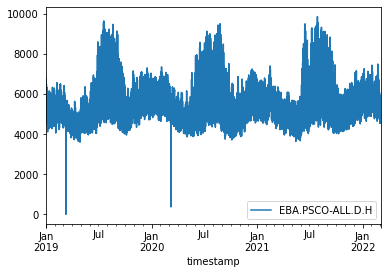

In [19]:
df.plot()

The same pattern is a little more clear if we plot the daily sum of energy demand.

<AxesSubplot:xlabel='timestamp'>

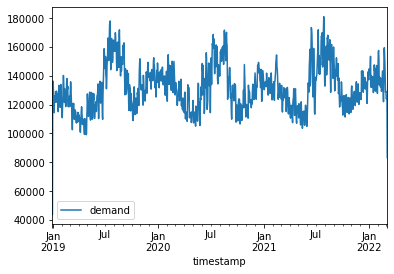

In [21]:
daily = df.resample('d').sum()
daily['demand'] = daily.sum(axis=1)
daily = daily[['demand']]
daily.plot()

There is a clear weekly cycle with more energy being used on the weekdays than on the weekends.

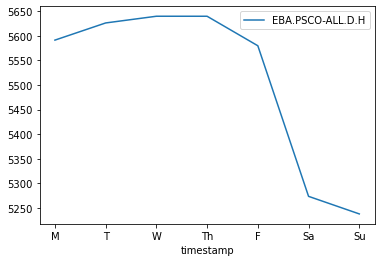

In [28]:
ax = df.groupby(df.index.dayofweek).mean().plot()
ax.set_xticks(range(0,7))
ax.set_xticklabels(['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']);

In [77]:
import matplotlib.pyplot as plt
hourly = (df
            .groupby([df.index.hour, df.index.month])
            .mean()
            .unstack()
        )
hourly.columns = hourly.columns.droplevel()
hourly.columns = calendar.month_abbr[1:]

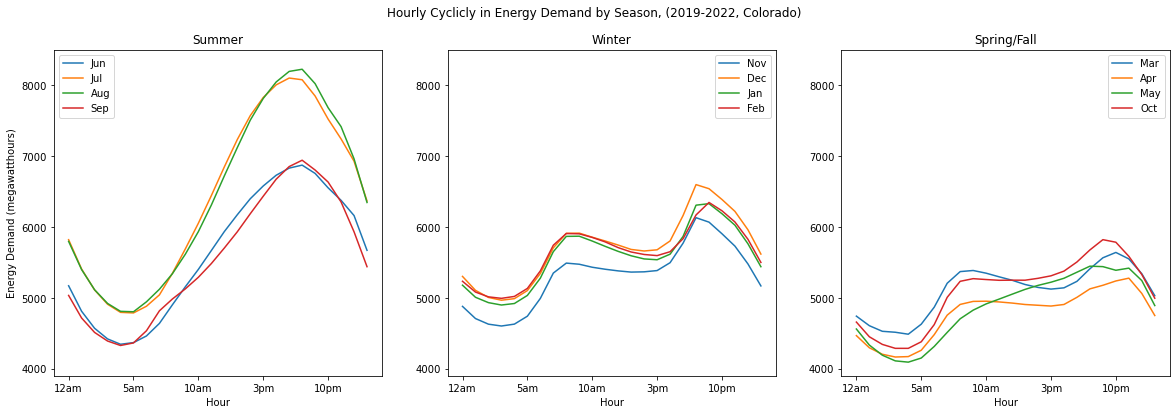

In [86]:

fig, ax = plt.subplots(ncols=3, figsize=(20, 6))
hourly[['Jun', 'Jul', 'Aug', 'Sep']].plot(ax=ax[0])
hourly[['Nov', 'Dec', 'Jan', 'Feb']].plot(ax=ax[1])
hourly[['Mar', 'Apr', 'May', 'Oct']].plot(ax=ax[2])

fig.suptitle('Hourly Cyclicity in Energy Demand by Season, (2019-2022, Colorado)')

ax[0].set_title('Summer')
ax[0].set_ylabel('Energy Demand (megawatthours)')

ax[1].set_title('Winter')
ax[2].set_title('Spring/Fall')
for a in ax:
    a.set_ylim((3900, 8500))
    a.set_xlabel('Hour')

    a.set_xticks([0, 5, 10, 15, 20])
    a.set_xticklabels(['12am', '5am', '10am', '3pm', '10pm']);

